<a href="https://colab.research.google.com/github/aytekin827/AIB_sec4_project/blob/main/project4_classification_turkish_language.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###필요 라이브러리 설치 및 불러오기


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from nltk import word_tokenize,sent_tokenize
import re # regular expression libary.
import nltk # Natural Language toolkit
from sklearn import preprocessing
import string
from nltk.corpus import stopwords
nltk.download("stopwords")
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
import warnings
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
warnings.filterwarnings(action='ignore')
from wordcloud import WordCloud
from collections import Counter

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
!pip install fasttext
!pip install simpletransformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# EDA

In [78]:
df = pd.read_csv('/content/drive/MyDrive/dataset/7allV03.csv',encoding='utf-8')
print(df.shape)
df.head()

(4900, 2)


,category,text
0,siyaset,3 milyon ile ön seçim vaadi mhp nin 10 olağan...
1,siyaset,mesut_yılmaz yüce_divan da ceza alabilirdi pr...
2,siyaset,disko lar kaldırılıyor başbakan_yardımcısı ar...
3,siyaset,sarıgül anayasa_mahkemesi ne gidiyor mustafa_...
4,siyaset,erdoğan idamın bir haklılık sebebi var demek ...


In [80]:
# 결측치 제거 -> 결측치 없음
df.isna().sum()

category    0
text        0
dtype: int64

In [81]:
# 중복값 제거
print(df.duplicated().sum())
df = df.drop_duplicates()
df.shape

360


(4540, 2)

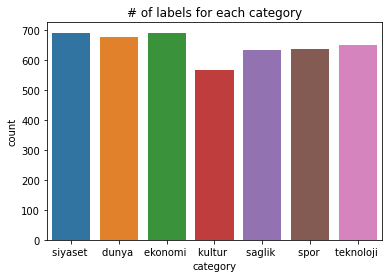

총 레이블 수 7
총 데이터 수 4540


In [82]:
sns.countplot("category",data=df)
plt.title('# of labels for each category')
plt.show() # balanced label
s = df['category'].nunique() # number of labels
n = df.shape[0]
print(f'총 레이블 수 {s}')
print(f'총 데이터 수 {n}')

# Prerocessing

In [83]:
text_list=[]

for text in df.text:
    text = text.lower()  #Büyük harften -Küçük harfe çevirme
    text = re.sub("[^abcçdefgğhıijklmnoöprsştuüvyz]"," ",text)
    text=nltk.word_tokenize(text) # splits the words that are in the sentence from each other.
    text =[word for word in text if not word in set(stopwords.words("turkish"))] # remove stopword 
    text=" ".join(text)
    text_list.append(text) # store sentences in list

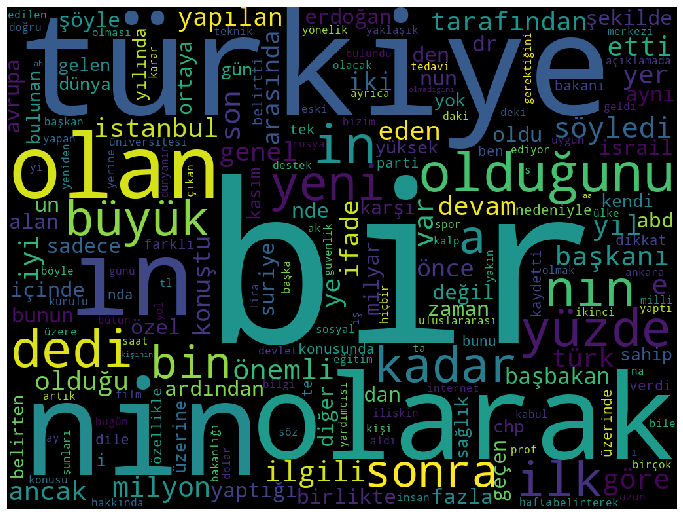

In [84]:
c = Counter(' '.join(text_list).split())

wc = WordCloud(background_color="black",width=1024,height=768).generate_from_frequencies(c)
plt.figure(figsize=(12,10))
plt.axis('off')
plt.imshow(wc, interpolation='nearest')
plt.show()

In [85]:
df['cleaned_text'] = text_list
df.head()

,category,text,cleaned_text
0,siyaset,3 milyon ile ön seçim vaadi mhp nin 10 olağan...,milyon ön seçim vaadi mhp nin olağan büyük kur...
1,siyaset,mesut_yılmaz yüce_divan da ceza alabilirdi pr...,mesut yılmaz yüce divan ceza alabilirdi prof d...
2,siyaset,disko lar kaldırılıyor başbakan_yardımcısı ar...,disko lar kaldırılıyor başbakan yardımcısı arı...
3,siyaset,sarıgül anayasa_mahkemesi ne gidiyor mustafa_...,sarıgül anayasa mahkemesi gidiyor mustafa sarı...
4,siyaset,erdoğan idamın bir haklılık sebebi var demek ...,erdoğan idamın bir haklılık sebebi var demek y...


In [116]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
labels=le.fit_transform(df.category)
df['label'] = labels
df.head()

,category,text,cleaned_text,label
0,siyaset,3 milyon ile ön seçim vaadi mhp nin 10 olağan...,milyon ön seçim vaadi mhp nin olağan büyük kur...,4
1,siyaset,mesut_yılmaz yüce_divan da ceza alabilirdi pr...,mesut yılmaz yüce divan ceza alabilirdi prof d...,4
2,siyaset,disko lar kaldırılıyor başbakan_yardımcısı ar...,disko lar kaldırılıyor başbakan yardımcısı arı...,4
3,siyaset,sarıgül anayasa_mahkemesi ne gidiyor mustafa_...,sarıgül anayasa mahkemesi gidiyor mustafa sarı...,4
4,siyaset,erdoğan idamın bir haklılık sebebi var demek ...,erdoğan idamın bir haklılık sebebi var demek y...,4


# modeling & evalutaion

## Fasttext

In [117]:
#data split for train and test

train, test = train_test_split(df, test_size=0.2, random_state=42)
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [118]:
train.head()

,category,text,cleaned_text,label
0,kultur,7 yaşındaki mercan a büyük ödül almanya nın e...,yaşındaki mercan a büyük ödül almanya nın önem...,2
1,teknoloji,facebook kullanıcıları dikkat ! facebook un y...,facebook kullanıcıları dikkat facebook un yeni...,6
2,saglik,organ bağışı vasiyeti herkesin cebinde olacak...,organ bağışı vasiyeti herkesin cebinde olacak ...,3
3,ekonomi,çeyrek altın kaç lira istanbul_kapalıçarşı da...,çeyrek altın kaç lira istanbul kapalıçarşı aya...,1
4,ekonomi,borsa güne yükselişle başladı istanbul_menkul...,borsa güne yükselişle başladı istanbul menkul ...,1


In [119]:
test.head()

,category,text,cleaned_text,label
0,ekonomi,hollanda türkiye  nin büyümesini kıskanıyoru...,hollanda türkiye nin büyümesini kıskanıyoruz h...,1
1,ekonomi,komşu türk turist çekmek için camileri bile o...,komşu türk turist çekmek camileri bile onaraca...,1
2,kultur,ünlü eser sakıncalı bulundu izmir il milli_eğ...,ünlü eser sakıncalı bulundu izmir il milli eği...,2
3,spor,ronaldo ile kıyaslanmaktan sıkılmış ! dünyanı...,ronaldo kıyaslanmaktan sıkılmış dünyanın iyi i...,5
4,dunya,meksika da deprem meksika nın güneyinde şidde...,meksika deprem meksika nın güneyinde şiddetli ...,0


In [120]:
#Data prepare for fasttext format for train
train["label_format"]=0
for i in range(len(train)):
    train.label_format[i]="__label__"+str(train.category[i])+" "+str(train.cleaned_text[i])

#Data prepare for fasttext format for test
test["label_format"]=0
for i in range(len(test)):
    test.label_format[i]="__label__"+str(test.category[i])+" "+str(test.cleaned_text[i])

In [121]:
train.head()

,category,text,cleaned_text,label,label_format
0,kultur,7 yaşındaki mercan a büyük ödül almanya nın e...,yaşındaki mercan a büyük ödül almanya nın önem...,2,__label__kultur yaşındaki mercan a büyük ödül...
1,teknoloji,facebook kullanıcıları dikkat ! facebook un y...,facebook kullanıcıları dikkat facebook un yeni...,6,__label__teknoloji facebook kullanıcıları dik...
2,saglik,organ bağışı vasiyeti herkesin cebinde olacak...,organ bağışı vasiyeti herkesin cebinde olacak ...,3,__label__saglik organ bağışı vasiyeti herkesi...
3,ekonomi,çeyrek altın kaç lira istanbul_kapalıçarşı da...,çeyrek altın kaç lira istanbul kapalıçarşı aya...,1,__label__ekonomi çeyrek altın kaç lira istanb...
4,ekonomi,borsa güne yükselişle başladı istanbul_menkul...,borsa güne yükselişle başladı istanbul menkul ...,1,__label__ekonomi borsa güne yükselişle başlad...


In [122]:
test.head()

,category,text,cleaned_text,label,label_format
0,ekonomi,hollanda türkiye  nin büyümesini kıskanıyoru...,hollanda türkiye nin büyümesini kıskanıyoruz h...,1,__label__ekonomi hollanda türkiye nin büyümes...
1,ekonomi,komşu türk turist çekmek için camileri bile o...,komşu türk turist çekmek camileri bile onaraca...,1,__label__ekonomi komşu türk turist çekmek cam...
2,kultur,ünlü eser sakıncalı bulundu izmir il milli_eğ...,ünlü eser sakıncalı bulundu izmir il milli eği...,2,__label__kultur ünlü eser sakıncalı bulundu i...
3,spor,ronaldo ile kıyaslanmaktan sıkılmış ! dünyanı...,ronaldo kıyaslanmaktan sıkılmış dünyanın iyi i...,5,__label__spor ronaldo kıyaslanmaktan sıkılmış...
4,dunya,meksika da deprem meksika nın güneyinde şidde...,meksika deprem meksika nın güneyinde şiddetli ...,0,__label__dunya meksika deprem meksika nın gün...


In [123]:
train.label_format.to_csv('fasttext_train.txt',index=None,header=None)
test.label_format.to_csv('fasttext_test.txt',index=None,header=None)

In [99]:
import fasttext
#train classifier model
model_fasttext = fasttext.train_supervised('fasttext_train.txt',
                                           epoch=50,
                                           lr=0.05,
                                           label_prefix='__label__',
                                           dim=1000)

In [124]:
# 전처리 한 데이터
train_acc = model_fasttext.test('fasttext_train.txt')
test_acc = model_fasttext.test('fasttext_test.txt')

print("train Accuracy:",str(train_acc[1]))
print("test Accuracy:",str(test_acc[1]))

train Accuracy: 0.9509911894273128
test Accuracy: 0.8777533039647577


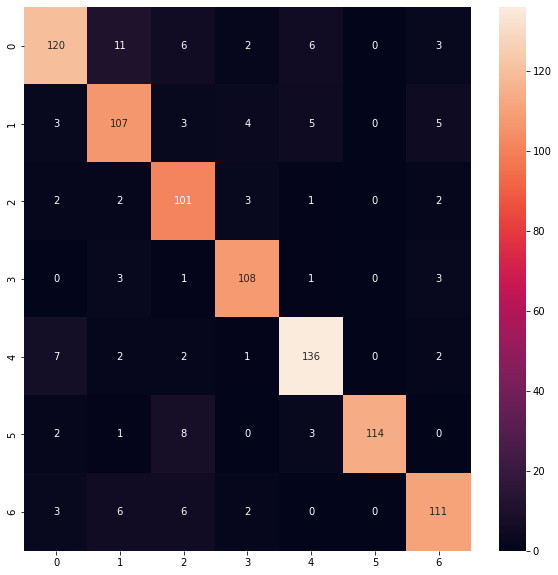

In [162]:
y_test = test['label']

y_pred_label = []
for text in test['cleaned_text']:
    text = model_fasttext.predict(text)[0][0][9:] + ' '
    y_pred_label.append(text)
    y_pred = le.transform(y_pred_label)

cm=confusion_matrix(y_test,y_pred)

plt.figure(figsize=(10,10))
sns.heatmap(cm,annot=True,fmt='d') 
plt.show()

## ML - RandomForest, Randomized Serach CV


In [26]:
# string label을 integer label로 변환하기
df['labels'] = pd.factorize(df.category)[0]
print(df.shape)
df.head()

(4540, 6)


,category,text,cleaned_text,tokenized_text,preprocessed_text,labels
0,siyaset,3 milyon ile ön seçim vaadi mhp nin 10 olağan...,milyon ile ön seçim vaadi mhp nin olağan bü...,"[ön, seçim, vaadi, mhp, nin, olağan, büyük, ku...",ön seçim vaadi mhp nin olağan büyük kurultayı ...,0
1,siyaset,mesut_yılmaz yüce_divan da ceza alabilirdi pr...,mesut_yılmaz yüce_divan da ceza alabilirdi pr...,"[mesut_yılmaz, yüce_divan, ceza, alabilirdi, p...",mesut_yılmaz yüce_divan ceza alabilirdi prof d...,0
2,siyaset,disko lar kaldırılıyor başbakan_yardımcısı ar...,disko lar kaldırılıyor başbakan_yardımcısı ar...,"[disko, lar, kaldırılıyor, başbakan_yardımcısı...",disko lar kaldırılıyor başbakan_yardımcısı arı...,0
3,siyaset,sarıgül anayasa_mahkemesi ne gidiyor mustafa_...,sarıgül anayasa_mahkemesi ne gidiyor mustafa_...,"[sarıgül, anayasa_mahkemesi, gidiyor, mustafa_...",sarıgül anayasa_mahkemesi gidiyor mustafa_sarı...,0
4,siyaset,erdoğan idamın bir haklılık sebebi var demek ...,erdoğan idamın bir haklılık sebebi var demek ...,"[erdoğan, idamın, haklılık, sebebi, demek, yer...",erdoğan idamın haklılık sebebi demek yeri geld...,0


In [63]:
stopwords

<WordListCorpusReader in '/root/nltk_data/corpora/stopwords'>

In [34]:
text_list=[]

for text in df.text:
    text = text.lower()  #Büyük harften -Küçük harfe çevirme
    text = re.sub("[^abcçdefgğhıijklmnoöprsştuüvyz]"," ",text)
    text=nltk.word_tokenize(text) # splits the words that are in the sentence from each other.
    text =[word for word in text if not word in set(stopwords.words("turkish"))] # remove stopword 
    lemma=nltk.WordNetLemmatizer()
    text=[lemma.lemmatize(word) for word in text] # this code finds the root of the word for a word in the sentence and change them to their root form.
    text=" ".join(text)
    text_list.append(text) # store sentences in list

In [39]:
from sklearn.feature_extraction.text import CountVectorizer #Bag of Words

max_features=500 # most commonly used 500 words in reviews

stop_words_turkish = pd.read_excel('/content/drive/MyDrive/dataset/turkish-stopwords.xls',names=['KELIME'])['KELIME'].tolist() 
# 터키어 불용어 출처 : https://countwordsfree.com/stopwords/turkish

count_vectorizer=CountVectorizer(stop_words=stop_words_turkish, max_features=max_features) 
sparce_matrix=count_vectorizer.fit_transform(text_list).toarray()
print(sparce_matrix.shape)
sparce_matrix

(4540, 500)


array([[0, 0, 0, ..., 0, 1, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 2, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [41]:
print("Top {} the most used word:\n {}".format(max_features,count_vectorizer.get_feature_names()))

Top 500 the most used word:
 ['aa', 'ab', 'abd', 'adet', 'adlı', 'adına', 'ahmet', 'ait', 'ak', 'akıllı', 'alan', 'aldı', 'aldığı', 'ali', 'almanya', 'altında', 'alınan', 'alıyor', 'amacıyla', 'an', 'ana', 'anayasa', 'ancak', 'anda', 'ankara', 'anlatan', 'anlattı', 'anne', 'apple', 'aralık', 'arasında', 'arasındaki', 'araya', 'araştırma', 'ardından', 'artık', 'arınç', 'askeri', 'avrupa', 'ay', 'aynı', 'ayrıca', 'ayında', 'açık', 'açıkladı', 'açıklama', 'açıklamada', 'açısından', 'ağır', 'bakan', 'bakanlığı', 'bakanı', 'basın', 'bağlı', 'başarılı', 'başbakan', 'başka', 'başkan', 'başkanı', 'başladı', 'başlayan', 'başında', 'bdp', 'belediye', 'belirten', 'belirterek', 'belirtildi', 'belirtti', 'ben', 'benim', 'beşiktaş', 'bildirdi', 'bildirildi', 'bile', 'bilgi', 'bilim', 'bin', 'bir', 'birlikte', 'birliği', 'birçok', 'bize', 'bizim', 'boyunca', 'bugün', 'bugüne', 'bulunan', 'bulundu', 'bulunduğu', 'bulunuyor', 'buna', 'bundan', 'bunlar', 'bunu', 'bunun', 'burada', 'böyle', 'bütün', 'büy

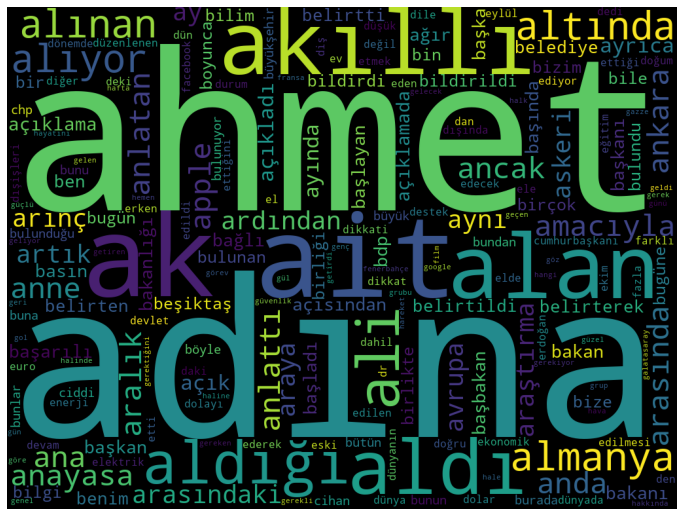

In [42]:
from wordcloud import WordCloud 
import matplotlib.pyplot as plt
plt.subplots(figsize=(12,12))
data=pd.DataFrame(count_vectorizer.get_feature_names(),columns=["Words"])
wordcloud=WordCloud(background_color="black",width=1024,height=768).generate(" ".join(data.Words[5:]))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# lemmatization 이 잘 안됬음 
# adına adlı adı 
# aldığı alan  
# 두개 모두 같은 의미

In [43]:
from sklearn import preprocessing

X=sparce_matrix
le = preprocessing.LabelEncoder()
labels=le.fit_transform(df.category)
y=labels

In [45]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42,shuffle=True)
print("x_train",X_train.shape)
print("x_test",X_test.shape)
print("y_train",y_train.shape)
print("y_test",y_test.shape)

x_train (3632, 500)
x_test (908, 500)
y_train (3632,)
y_test (908,)


In [46]:
# random forest classifier
from sklearn.ensemble import RandomForestClassifier

rf_model=RandomForestClassifier(random_state=42)
rf_model.fit(X_train,y_train)

RandomForestClassifier(random_state=42)

Accuracy: 0.8116740088105727
Precision: 0.8116740088105727


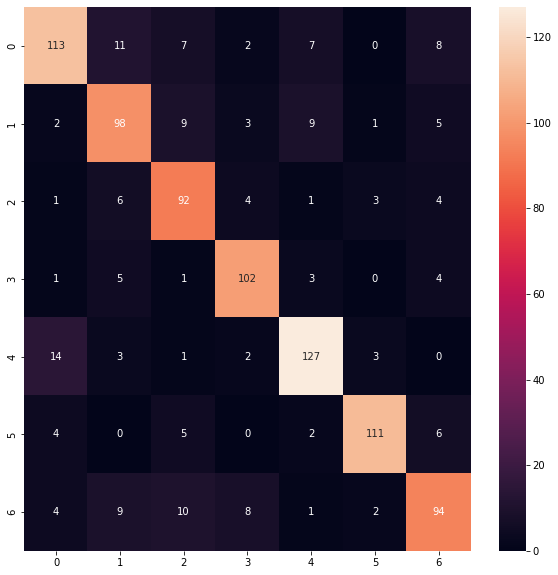

In [49]:
# result
# RandomForest model - simple
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report,precision_score

y_pred=rf_model.predict(X_test)

print("Accuracy:",accuracy_score(y_test, y_pred))
print("Precision:",precision_score(y_test, y_pred,average="micro"))

cm=confusion_matrix(y_test,y_pred)

plt.figure(figsize=(10,10))
sns.heatmap(cm,annot=True,fmt='d') 
plt.show()

In [51]:
# model fine tuning
rf_params={"max_depth":[2,5,8,10],
           "max_features":[2,5,8],
           "n_estimators":[10,500,1000],
          "min_samples_split":[2,5,10]}

In [52]:
from sklearn.model_selection import RandomizedSearchCV

rf=RandomForestClassifier(random_state=42)
rf_cv=RandomizedSearchCV(rf,rf_params,cv=10,n_jobs=-1,verbose=2)
rf_cv_model=rf_cv.fit(X_train,y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [53]:
print(rf_cv_model.best_params_)
print(rf_cv_model.best_score_)

{'n_estimators': 1000, 'min_samples_split': 2, 'max_features': 8, 'max_depth': 8}
0.7725925589561953


In [54]:
rf_tuned_model=RandomForestClassifier(random_state=42,
                                      max_depth=8,
                                      max_features= 8,
                                      min_samples_split= 2,
                                      n_estimators= 1000)

rf_tuned_model.fit(X_train,y_train)

RandomForestClassifier(max_depth=8, max_features=8, n_estimators=1000,
                       random_state=42)

Accuracy: 0.7830396475770925
Precision: 0.7830396475770925


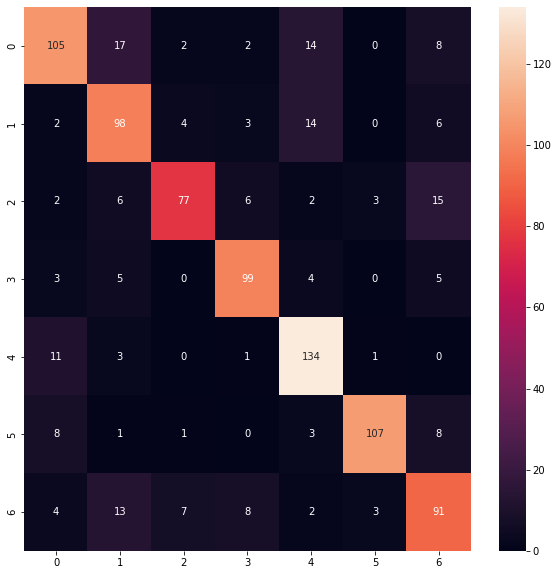

In [55]:
# result
# hyper parameter fine tuning

y_pred=rf_tuned_model.predict(X_test)

print("Accuracy:",accuracy_score(y_test, y_pred))
print("Precision:",precision_score(y_test, y_pred,average="micro"))

cm=confusion_matrix(y_test,y_pred)

plt.figure(figsize=(10,10))
sns.heatmap(cm,annot=True,fmt='d') 
plt.show()

## Deep learning - LSTM

In [56]:
X = df.text
X_list=[] # store text in this list

for text in X:
    text = text.lower()
    text = re.sub("[^abcçdefgğhıijklmnoöprsştuüvyz]"," ",text)
    text = text.split()
    text =[word for word in text if not word in set(stopwords.words("turkish"))]
    text=" ".join(text)
    X_list.append(text) # store sentences in list

In [57]:
y_label=[]

for i in labels:
    y_label.append(i)

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X_list, y_label, test_size=0.2, random_state=42,shuffle=True)
print(len(X_train)) # 3920 sentences
print(len(y_train)) #3920 Labels
print(len(X_test))  # 980 sentences
print(len(y_test)) # 980 labels

3632
3632
908
908


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences 

max_lenght=100

tokenizer = Tokenizer() 
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index # creating word dict for words in training

sequences = tokenizer.texts_to_sequences(X_train)  # replacing words with the number corresponding to them in the dictionary(word_index)

X_train_padded = pad_sequences(sequences, padding='post',maxlen=max_lenght) # padding words

print(len(word_index)) # I have 94836 words in my dictionary

In [ ]:
print("Original Version:",X_train[0])
print("\n---------------------------------\n")
print("Tokenized version:",sequences[0])  # change words with number that corresponding to word word_index
print("\n---------------------------------\n")
print("Padded version",X_train_padded[0]) 
print("\n---------------------------------\n")
print("Shape after the padding:",X_train_padded.shape)

In [ ]:
X_test_sequences = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_sequences,padding="post",maxlen=max_lenght)

In [ ]:
print("Original Version:",X_test[0])
print("\n---------------------------------\n")
print("Tokenized version:",X_test_sequences[0])  # change words with number that corresponding to word word_index
print("\n---------------------------------\n")
print("Padded version",X_test_padded[0]) 
print("\n---------------------------------\n")
print("Shape after the padding:",X_test_padded.shape)

In [ ]:
y_train_label=np.asarray(y_train).reshape(-1,1)
y_test_label=np.asarray(y_test).reshape(-1,1)

In [ ]:
import tensorflow as tf

vocab_size = len(tokenizer.word_index)+1
embedding_dim=16

model_lstm2 = tf.keras.models.Sequential([
  tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=100),
  tf.keras.layers.LSTM(128, dropout=0.2, recurrent_dropout=0.2),
  tf.keras.layers.Dense(7, activation='softmax')
])

model_lstm2.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model_lstm2.summary()

In [ ]:
num_epochs = 10
BATCH_SIZE=64
history=model_lstm2.fit(X_train_padded,y_train_label,batch_size=BATCH_SIZE ,epochs=num_epochs, validation_data=(X_test_padded,y_test_label))

In [ ]:
# model_lstm
import matplotlib.pyplot as plt

plt.plot(history.history["accuracy"],color="green")
plt.plot(history.history["loss"],color="red")
plt.title("Train accuracy and Train loss")
plt.legend(["Accuracy","Loss"])
plt.grid()


In [ ]:
# model_lstm
plt.plot(history.history["val_accuracy"],color="blue")
plt.plot(history.history["val_loss"],color="orange")
plt.title("Test accuracy and Test loss")
plt.legend(["Val_accuracy","Val_loss"])
plt.grid()

In [ ]:
import tensorflow as tf

vocab_size = len(tokenizer.word_index)+1
embedding_dim=16

model_lstm2 = tf.keras.Sequential([
    
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=100),
    
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(7, activation='softmax')
])

adam= tf.keras.optimizers.Adam(lr=0.01) 

model_lstm2.compile(loss='sparse_categorical_crossentropy',optimizer=adam,metrics=['accuracy'])
model_lstm2.summary()

In [ ]:
num_epochs = 10
BATCH_SIZE=64
history2=model_lstm2.fit(X_train_padded,y_train_label,batch_size=BATCH_SIZE ,epochs=num_epochs, validation_data=(X_test_padded,y_test_label))

In [ ]:
# model_lstm2
import matplotlib.pyplot as plt

plt.plot(history2.history["accuracy"],color="green")
plt.plot(history2.history["loss"],color="red")
plt.title("Train accuracy and Train loss")
plt.legend(["Accuracy","Loss"])
plt.grid()

In [ ]:
# model_lstm2
plt.plot(history2.history["val_accuracy"],color="blue")
plt.plot(history2.history["val_loss"],color="orange")
plt.title("Test accuracy and Test loss")
plt.legend(["Val_accuracy","Val_loss"])
plt.grid()

In [ ]:
print("Accuracy of the model on Training Data is - " , model_lstm3.evaluate(X_train_padded,y_train_label)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , model_lstm3.evaluate(X_test_padded,y_test_label)[1]*100 , "%")

pred = np.argmax(model_lstm2.predict(X_test_padded),axis=1)
cm = confusion_matrix(y_test,pred)
plt.figure(figsize=(10,10))
sns.heatmap(cm,annot=True,linecolor="white",fmt='')
# overfitted on training data

## Deep learning - BERTurkish


In [ ]:
from simpletransformers.classification import ClassificationModel

In [ ]:
#for bert text column should be string and label column should be int
train["text"]=train["text"].apply(lambda r: str(r))
train['labels']=train['labels'].astype(int)

In [ ]:
#create model with turkish bert - transfer learning
model = ClassificationModel('bert', 'dbmdz/bert-base-turkish-uncased', num_labels=7,use_cuda=False,
                            args={'reprocess_input_data': True, 
                                  'overwrite_output_dir': True, 
                                  'num_train_epochs': 3, 
                                  "train_batch_size": 64 , 
                                  "fp16":False,
                                  "output_dir": "bert_model"})

In [ ]:
#train model
model.train_model(train)

In [ ]:
result, model_outputs, wrong_predictions = model.eval_model(test)

In [ ]:
from sklearn import metrics
print(metrics.classification_report(actuals, predictions, digits=3))

In [ ]:
from sklearn.metrics import accuracy_score
predictions = model_outputs.argmax(axis=1)
actuals = test.labels.values
print(metrics.classification_report(actuals, predictions, digits=3))
accuracy_score(actuals, predictions)